# Rotation curve

In [1]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.coordinates as coord
from scipy.integrate import solve_ivp
from astropy.io import ascii
from scipy import optimize
from scipy import interpolate
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import config as cfg
from galpy.potential.mwpotentials import MWPotential2014
from galpy.potential import plotRotcurve
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/mmestre/.conda/envs/cosmos/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)

V_c(R_sun)= 201.75312894152472


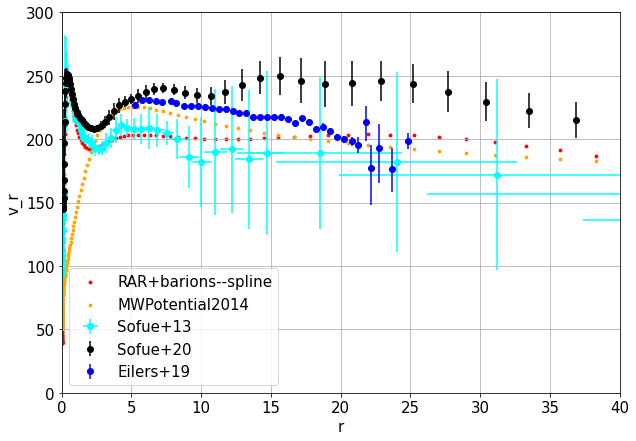

In [9]:
# Rotation velocity
import accelerations as ac
import potential_classes as pot


def accel_mw(x,y,z):
    return bulge.accel(x,y,z)+thin.accel(x,y,z)+thick.accel(x,y,z)+halo.accel(x,y,z)

def grad_mw(x,y,z):
    return -accel_mw(x,y,z)

def rot_vel_mw(r):
    return np.sqrt(r*(grad_mw(r,0,0)[0]))

def galpy_vcirc(r):
    mwp = MWPotential2014
    a= mwp[0].vcirc(r*u.kpc)
    b= mwp[1].vcirc(r*u.kpc)
    c= mwp[2].vcirc(r*u.kpc)
    return np.sqrt(a*a+b*b+c*c)

# Set rotation data
exec(open("./vel_Sofue13.py").read())
v_Sof20=pd.read_csv('vel_Sofue20.txt', sep=" ")
v_Eilers = pd.read_csv('vel_Eilers.txt', sep="  ")
asym_error = [v_Eilers['e_down'], v_Eilers['e_up']]

# Set barionic potentials
M_gal=2.32e7  # Msun
bulge = pot.Plummer(460.0*M_gal,0.3)
thin = pot.MiyamotoNagai(1700.0*M_gal,5.3,0.25)
thick= pot.MiyamotoNagai(1700.0*M_gal,2.6,0.8)


# Set halo potential
ener_f = 56.0  # keV
theta_0, W_0, beta_0 = 3.77780827e+01, 6.63468885e+01, 1.20446329e-05
# theta_0 = 3.623511473208260014e+01
# W_0 = theta_0 + 2.745737545624503895e+01
# beta_0 = 1.1977e-5
param = np.array([ener_f,theta_0, W_0, beta_0 ])  
halo = pot.RAR(param)

# Compute circular velocities
r_vec=np.logspace(-3,3,200)
v_vec = [rot_vel_mw(x) for x in r_vec]
v_galpy = [220*galpy_vcirc(x) for x in r_vec]
print('V_c(R_sun)=',rot_vel_mw(8.129))


# Plot
fig = plt.figure(figsize=(10,7))
font = {"size": 15}  
plt.rc('font', **font)
plt.scatter(r_vec,v_vec,s=8,marker='o', color='red', label='RAR+barions--spline')
plt.scatter(r_vec,v_galpy,s=8,marker='o', color='orange',label='MWPotential2014')
plt.errorbar(v_Sof['r']/1.e3, v_Sof['v'], xerr=v_Sof['err_r']/1.e3 ,yerr=v_Sof['err_v'], fmt='o', color='cyan', label='Sofue+13')
plt.errorbar(v_Sof20['Radius'],v_Sof20['Velocity'],yerr=v_Sof20['Error'],fmt='o',color='black',label='Sofue+20')
plt.errorbar(v_Eilers['r'],v_Eilers['v'],yerr=asym_error,fmt='o',color='blue',label='Eilers+19')
plt.xlim(0,40)
plt.ylim(0,300)
plt.xlabel('r')
plt.ylabel('v_r')
plt.grid(True)
plt.legend()
#plt.xscale('symlog')
plt.savefig('plots/rotation_curve.png')

In [5]:
print(2**10,10**4)

1024 10000
